In [ ]:
pip install -U langgraph

In [ ]:
# 필요한 타입 힌트와 그래프 클래스 불러오기
from typing import TypedDict  # 딕셔너리 형태의 데이터에 타입을 지정할 수 있게 해주는 모듈

# Annotated는 나중에 타입에 부가 정보를 달 때 사용할 수 있습니다. (이번 예제에서는 사용하지 않음)
from typing import Annotated

# LangGraph에서 상태 그래프와 시작/끝 지점을 가져옵니다.
from langgraph.graph import StateGraph, START, END # LangGraph에서 그래프 생성에 필요한 요소들 불러오기

# 1.상태(state)의 틀을 정의
# 이 틀은 그래프 안에서 각 노드가 주고받을 정보를 명확하게 정의해 줍니다.
class State(TypedDict):
  counter: int          # 정수형 카운터, 노드가 실행될 때마다 1씩 증가시킬 예정입니다.
  alphabet: list[str]   # 문자열 리스트, 예: ["Hello"]와 같은 값을 저장할 수 있습니다.

# 2. 상태 그래프(State Graph) 생성
# 위에서 정의한 State라는 상태 틀을 기반으로 LangGraph의 상태 그래프를 만듭니다.
# 이 그래프는 노드 간 데이터가 정해진 구조(State)에 따라 전달되도록 보장합니다.
# 입력: state (위에서 정의한 State 타입을 따릅니다)
# 출력: 수정된 state를 그대로 반환합니다.
def node_a(state: State):
  state['counter'] += 1           # counter 값을 1 증가시킵니다.
  state['alphabet'] = ["Hello"]   # alphabet 필드에 "Hello"라는 문자열을 리스트로 저장합니다.
  return state                    # 수정된 state를 반환합니다.


# 그래프를 만들기 위한 빌더 객체를 생성합니다.
# 여기서 우리가 정의한 State 클래스를 사용해 그래프의 상태 정보를 명시합니다.
graph_builder = StateGraph(State)

# 그래프에 노드를 추가합니다.
# "Songwooseok AI"라는 이름의 노드를 만들고, 이 노드는 node_a라는 함수를 실행합니다.
graph_builder.add_node("Songwooseok AI", node_a)

# 그래프의 시작 지점(START)에서 "Songwooseok AI" 노드로 연결되는 엣지를 추가합니다.
graph_builder.add_edge(START, "Songwooseok AI")

# "Songwooseok AI" 노드에서 끝 지점(END)으로 이어지는 엣지를 추가합니다.
graph_builder.add_edge("Songwooseok AI", END)

# 그래프를 컴파일하여 실행 가능한 형태로 만듭니다.
# 이렇게 하면 입력값을 주었을 때 노드를 통과하며 상태가 업데이트되는 그래프가 완성됩니다.
graph = graph_builder.compile()


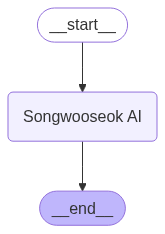

In [ ]:
# 그래프 시각화
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
initial_state ={
    "counter": 0 ,
  "alphabet": []
}
state  = initial_state

for _ in range(3):
  state = graph.invoke(state)
  print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello']}
{'counter': 3, 'alphabet': ['Hello']}


In [ ]:
# 이번엔 누적(add) 방식으로 병합될 수 있도록 Annotated 사용

import operator

class State(TypedDict):
  counter: int
  alphabet: Annotated[list[str],operator.add] #########3
def node_a(state: State):
  state['counter'] += 1
  state['alphabet'] = ["Hello"]
  return state


graph_builder = StateGraph(State)
graph_builder.add_node("Songwooseok AI", node_a)
graph_builder.add_edge(START, "Songwooseok AI")
graph_builder.add_edge("Songwooseok AI", END)
graph = graph_builder.compile()

initial_state ={
    "counter": 0 ,
  "alphabet": []
}
state  = initial_state

for _ in range(3):
  state = graph.invoke(state)
  print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello', 'Hello']}
{'counter': 3, 'alphabet': ['Hello', 'Hello', 'Hello']}


In [ ]:
!pip install langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.4/438.4 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.60
    Uninstalling langchain-core-0.3.60:
      Successfully uninstalled langchain-core-0.3.60


# Message를 담는 그래프 만들기

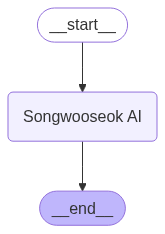

In [ ]:
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages: Annotated[list[str],add_messages] ####       # 'messages'라는 키를 가진 리스트를 상태로 정의하며, 이 리스트는 누적(additive) 방식으로 메시지를 추가함


graph_builder = StateGraph(State)


from langchain_openai import ChatOpenAI
import os
os.environ["OPENAI_API_KEY"] = ''

llm = ChatOpenAI(model = "gpt-4o-mini")

def chatbot(state: State):
  return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("Songwooseok AI", chatbot) # 위 chatbot 함수를 그래프의 하나의 노드로 추가, 노드 이름은 "Songwooseok AI"
graph_builder.set_entry_point("Songwooseok AI")
graph_builder.set_finish_point("Songwooseok AI")
graph = graph_builder.compile()

# 그래프 시각화
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
while True:
  user_input = input("우석: ")
  if user_input.lower() in ["quit","exit","q"]:
    print("빠이")
    break
  for event in graph.stream({"messages": ("user",user_input)}):
    for value in event.values():
      print("SongAI:", value["messages"][-1].content)

우석: 하윙
SongAI: 안녕하세요! 어떻게 도와드릴까요?
우석: 공부 재밌다^^
SongAI: 공부가 재밌다니 정말 좋은 거네요! 어떤 과목이나 주제가 특히 재미있나요? 같이 이야기해봐요!
우석: quit
빠이


In [ ]:
# 이제 state 클래스 매번 만드는 거 귀찮으니까, MessagesState 사용
from langgraph.graph import MessagesState

graph_builder = StateGraph(MessagesState)
def chatbot(state: State):
  return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("Songwooseok AI", chatbot)
graph_builder.set_entry_point("Songwooseok AI")
graph_builder.set_finish_point("Songwooseok AI")
graph = graph_builder.compile()



In [ ]:
while True:
  user_input = input("우석: ")
  if user_input.lower() in ["quit","exit","q"]:
    print("빠이")
    break
  for event in graph.stream({"messages": ("user",user_input)}):
    for value in event.values():
      print("SongAI:", value["messages"][-1].content)

우석: 이것도 되네
SongAI: 네, 맞아요! 어떤 도움이 필요하신가요? 궁금한 점이나 이야기하고 싶은 주제가 있으면 말씀해 주세요.
우석: q
빠이


In [ ]:
# MessaggesState 상속해서 사용하면서, 특성 추가 해서 사용할 수도 있음.

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage
class State(MessagesState):
  counter: int ##################

graph_builder = StateGraph(State)
def chatbot(state: State):
  state['counter'] = state.get('counter',0) +1  # counter가 없으면 0으로 지정하고, 있으면 1을 더해라
  return {"messages": [llm.invoke(state["messages"])],
          "counter":state['counter']
          }

graph_builder.add_node("Songwooseok AI", chatbot)
graph_builder.set_entry_point("Songwooseok AI")
graph_builder.set_finish_point("Songwooseok AI")
graph = graph_builder.compile()

initial_state ={
    "messages": [HumanMessage(content = "하이")],
    "counter": 0

}

result= graph.invoke(initial_state)

print(result) # result보면 ai 응답과 counter값 1로 업데이트 된거 볼 수 있음

{'messages': [HumanMessage(content='하이', additional_kwargs={}, response_metadata={}, id='4b248011-2955-4ef6-9917-0c16c49697bb'), AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-Bc92nLb4mr4mvCugA3VU5MSVF6iju', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--49e0b637-e76b-4560-9fb6-01747f7f402c-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})], 'counter': 1}


In [ ]:
state = initial_state
for _ in range(3):
  state = graph.invoke(state)
  print(f"Counter: {state['counter']}")
  print(f"Last messages: {state['messages'][-1].content}")
  print("____________________________")

Counter: 1
Last messages: 안녕하세요! 어떻게 도와드릴까요?
____________________________
Counter: 2
Last messages: 안녕하세요! 무엇을 도와드릴까요? 필요한 정보나 질문이 있으면 말씀해 주세요.
____________________________
Counter: 3
Last messages: 안녕하세요! 무엇을 도와드릴까요? 필요한 정보나 질문이 있으면 말씀해 주세요.
____________________________
